# Generating reports from images inference interactive script

In [33]:
from collections import defaultdict

import albumentations as A
import cv2
import evaluate
import spacy
import torch
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

import sys
sys.path.append("/home/hermione/Documents/VLP/TUM/rgrg_pretrained/")
from src.full_model.report_generation_model import ReportGenerationModel
from src.full_model.train_full_model import get_tokenizer

cuda_device_to_see = 1
os.environ['CUDA_VISIBLE_DEVICES'] = f'{cuda_device_to_see}'
device = torch.device(f"cuda:{cuda_device_to_see}" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(cuda_device_to_see)
print("device: ", device)

BERTSCORE_SIMILARITY_THRESHOLD = 0.9
IMAGE_INPUT_SIZE = 512
MAX_NUM_TOKENS_GENERATE = 300
NUM_BEAMS = 4
mean = 0.471  # see get_transforms in src/dataset/compute_mean_std_dataset.py
std = 0.302

device:  cuda:1


In [34]:
def write_generated_reports_to_txt(images_paths, reports, generated_reports, generated_reports_txt_path):
    with open(generated_reports_txt_path, "w") as f:
        for image_path, ref, gen in zip(images_paths, reports, generated_reports):
            f.write(f"Image path: {image_path}\n")
            f.write(f"Generated report: {gen}\n\n")
            f.write(f"reports: {ref}\n\n")
            f.write("=" * 30)
            f.write("\n\n")

In [36]:
def get_report_for_image(model, image_tensor, tokenizer, bert_score, sentence_tokenizer):
    with torch.autocast(device_type="cuda", dtype=torch.float16):
        output = model.generate(
            image_tensor.to(device, non_blocking=True),
            max_length=MAX_NUM_TOKENS_GENERATE,
            num_beams=NUM_BEAMS,
            early_stopping=True,
        )

    beam_search_output = output

    generated_sents_for_selected_regions = tokenizer.batch_decode(
        beam_search_output, skip_special_tokens=True, clean_up_tokenization_spaces=True
    )  # list[str]

    """ generated_report = convert_generated_sentences_to_report(
        generated_sents_for_selected_regions, bert_score, sentence_tokenizer
    )   """# str
    generated_report = generated_sents_for_selected_regions
    return generated_report


def get_image_tensor(image_path):
    # cv2.imread by default loads an image with 3 channels
    # since we have grayscale images, we only have 1 channel and thus use cv2.IMREAD_UNCHANGED to read in the 1 channel
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)  # shape (3056, 2544)

    val_test_transforms = A.Compose(
        [
            A.LongestMaxSize(max_size=IMAGE_INPUT_SIZE, interpolation=cv2.INTER_AREA),
            A.PadIfNeeded(min_height=IMAGE_INPUT_SIZE, min_width=IMAGE_INPUT_SIZE, border_mode=cv2.BORDER_CONSTANT),
            A.Normalize(mean=mean, std=std),
            ToTensorV2(),
        ]
    )

    transform = val_test_transforms(image=image)
    image_transformed = transform["image"]  # shape (1, 512, 512)
    image_transformed_batch = image_transformed.unsqueeze(0)  # shape (1, 1, 512, 512)

    return image_transformed_batch

def get_model(checkpoint_path):
    checkpoint = torch.load(
        checkpoint_path,
        map_location=torch.device("cpu"),
    )

    # if there is a key error when loading checkpoint, try uncommenting down below
    # since depending on the torch version, the state dicts may be different
    # checkpoint["model"]["object_detector.rpn.head.conv.weight"] = checkpoint["model"].pop("object_detector.rpn.head.conv.0.0.weight")
    # checkpoint["model"]["object_detector.rpn.head.conv.bias"] = checkpoint["model"].pop("object_detector.rpn.head.conv.0.0.bias")
    model = ReportGenerationModel(pretrain_without_lm_model=False)
    model.load_state_dict(checkpoint["model"])
    model.to(device, non_blocking=False)
    model.eval()

    del checkpoint

    return model


In [46]:
checkpoint_path = "/home/hermione/Documents/VLP/TUM/rgrg_pretrained/src/runs/full_model/run_21/saved_checkpoint/checkpoint_val_loss_2.060_overall_steps_258410.pt"
checkpoint_path = "/home/hermione/Documents/VLP/TUM/rgrg_pretrained/src/runs/full_model/run_20/checkpoints/checkpoint_val_loss_1.778_overall_steps_501150.pt"
checkpoint_path = "/home/hermione/Documents/VLP/TUM/rgrg_pretrained/src/runs/full_model/run_22/checkpoints/checkpoint_val_loss_2.034_overall_steps_309551.pt"
model = get_model(checkpoint_path)

print("Model instantiated.")

Model instantiated.


In [45]:
import pandas as pd
#train_final.to_csv("/home/hermione/Documents/data/rgrg/dataset-with-reference-reports/train_subset.csv",index=False)
val_final = pd.read_csv("/home/hermione/Documents/data/rgrg/dataset-with-reference-reports/test.csv")
val_final = pd.read_csv("/home/hermione/Documents/data/rgrg/dataset-with-reference-reports/test_card_vs_PE.csv")
val_final

,subject_id,study_id,image_id,mimic_image_file_path,reference_report
0,10005866,56175428,5d612499-b20019dc-d3324174-33b669e4-95ced958,/home/hermione/Documents/data/physionet.org/fi...,"Endotracheal tube tip is slightly low lying, t..."
1,10010471,59553780,eb4d5fb1-e0d7593f-e0a93f00-fe6e05b7-6fa1fe1e,/home/hermione/Documents/data/physionet.org/fi...,There are moderate bilateral pleural effusions...
2,10013569,53407104,2bf1576a-cb1775c8-7235d1b9-91495ebc-f93e4a0a,/home/hermione/Documents/data/physionet.org/fi...,Single AP upright portable view of the chest w...
3,10013569,56197670,7930aea9-d0108eda-0487f13b-5d2680c4-bd93f369,/home/hermione/Documents/data/physionet.org/fi...,"As compared to the previous radiograph, the Sw..."
4,10013569,57151026,63af38ce-8915b633-19f3a00b-3d6fde60-675b3525,/home/hermione/Documents/data/physionet.org/fi...,Portable AP chest radiograph demonstrates a la...
...,...,...,...,...,...
2600,11939844,57642216,01214854-6fbde20f-61bb6743-043ee819-2115c3f5,/home/hermione/Documents/data/physionet.org/fi...,Single portable view of the chest. The lungs a...
2601,12098619,58272842,d45916d9-f581f3c1-9c66e129-6bc0e8be-369bce53,/home/hermione/Documents/data/physionet.org/fi...,AP view of the chest. There are low lung volum...
2602,12252135,52701608,46accdd1-652c0175-9aca6183-6caabf21-5537bc63,/home/hermione/Documents/data/physionet.org/fi...,"Chest, PA and lateral. Lung volumes are low du..."
2603,12252135,52701608,eb03675d-31525034-9f6cda2b-6a71a695-bffe1bf7,/home/hermione/Documents/data/physionet.org/fi...,"Chest, PA and lateral. Lung volumes are low du..."


In [47]:
#ids = ["p10/p10001038/s58224503","p10/p10002428/s54831516"]
#im_ids = ["28fad2ac-d6001216-b4f72c5b-2d4d452e-17b6c9a5", "852306b6-02fc04aa-82d30dbf-0c2dd18d-5c9ef054"]
import os
im_ids = val_final["image_id"]
ids = "p"+val_final["subject_id"].astype(str) + os.sep +"s"+ val_final["study_id"].astype(str)
print(ids[:5])
im_ids = list(im_ids[:100])
ids = list(ids[:100])

0    p10005866/s56175428
1    p10010471/s59553780
2    p10013569/s53407104
3    p10013569/s56197670
4    p10013569/s57151026
dtype: object


In [48]:

# paths to the images that we want to generate reports for
images_paths = []
reports_paths = []
for n,i in enumerate(ids):
    images_paths.append(f"/home/hermione/Documents/data/physionet.org/files/mimic-cxr-jpg/2.0.0/files/p10/{i}/{im_ids[n]}.jpg")
    reports_paths.append(f"/home/hermione/Documents/data/physionet.org/files/mimic-cxr/2.0.0/mimic-cxr-reports/files/p10/{i}.txt")

print(images_paths)
print(reports_paths)

['/home/hermione/Documents/data/physionet.org/files/mimic-cxr-jpg/2.0.0/files/p10/p10005866/s56175428/5d612499-b20019dc-d3324174-33b669e4-95ced958.jpg', '/home/hermione/Documents/data/physionet.org/files/mimic-cxr-jpg/2.0.0/files/p10/p10010471/s59553780/eb4d5fb1-e0d7593f-e0a93f00-fe6e05b7-6fa1fe1e.jpg', '/home/hermione/Documents/data/physionet.org/files/mimic-cxr-jpg/2.0.0/files/p10/p10013569/s53407104/2bf1576a-cb1775c8-7235d1b9-91495ebc-f93e4a0a.jpg', '/home/hermione/Documents/data/physionet.org/files/mimic-cxr-jpg/2.0.0/files/p10/p10013569/s56197670/7930aea9-d0108eda-0487f13b-5d2680c4-bd93f369.jpg', '/home/hermione/Documents/data/physionet.org/files/mimic-cxr-jpg/2.0.0/files/p10/p10013569/s57151026/63af38ce-8915b633-19f3a00b-3d6fde60-675b3525.jpg', '/home/hermione/Documents/data/physionet.org/files/mimic-cxr-jpg/2.0.0/files/p10/p10013569/s57874790/f1057fa6-32b37b7c-913c3d01-dcd710bc-b269dde8.jpg', '/home/hermione/Documents/data/physionet.org/files/mimic-cxr-jpg/2.0.0/files/p10/p10013

0it [00:00, ?it/s]

p10005866/s56175428


1it [00:01,  1.03s/it]

p10010471/s59553780


2it [00:02,  1.04s/it]

generated reports:  ['As compared to the previous radiograph, there is no relevant change in the appearance of the cardiac silhouette. No pleural effusion or pneumothorax is seen.']
reference report:                                   FINAL REPORT
 EXAMINATION:
 Chest:  Frontal and lateral views
 
 INDICATION:  History: ___F with sob  // eval for pulm edema
 
 TECHNIQUE:  Chest:  Frontal and Lateral
 
 COMPARISON:  None.
 
 FINDINGS: 
 
 There are moderate bilateral pleural effusions with overlying atelectasis. 
 The cardiac silhouette is mild to moderately enlarged.  There is prominence of
 the bilateral central pulmonary vasculature worrisome for pulmonary edema. 
 Right infrahilar opacity may be due to combination of pleural effusion and
 atelectasis, but underlying consolidation or other pulmonary lesion not
 excluded.  Recommend follow-up chest imaging following acute episode/diuresis.
 The aorta is calcified.
 
 IMPRESSION: 
 
 Moderate bilateral pleural effusions with overlying a

3it [00:03,  1.04s/it]

p10013569/s56197670


4it [00:04,  1.12s/it]

p10013569/s57151026


5it [00:05,  1.08s/it]

p10013569/s57874790


6it [00:06,  1.07s/it]

p10013643/s53841005


7it [00:07,  1.02s/it]

p10013643/s58785837


8it [00:08,  1.03s/it]

p10015860/s55513261


9it [00:09,  1.02s/it]

p10018081/s50515796


10it [00:10,  1.02s/it]

p10018081/s51219318


11it [00:11,  1.02s/it]

p10018081/s51961926


12it [00:12,  1.02s/it]

p10018081/s52241060


13it [00:13,  1.01s/it]

p10018081/s52355329


14it [00:14,  1.01s/it]

p10018081/s52355329


15it [00:15,  1.03s/it]

p10018081/s53262913


16it [00:16,  1.07s/it]

p10018081/s55554731


17it [00:17,  1.06s/it]

p10018081/s55879987


18it [00:18,  1.05s/it]

p10018081/s55937781


19it [00:19,  1.04s/it]

p10018081/s56942504


20it [00:20,  1.03s/it]

p10018081/s57481090


21it [00:21,  1.01s/it]

p10018081/s57486705


22it [00:22,  1.01s/it]

p10018081/s58175153


23it [00:23,  1.01s/it]

p10018081/s58479559


24it [00:24,  1.01s/it]

p10018423/s50526690


25it [00:25,  1.01it/s]

p10018423/s51545426


26it [00:26,  1.01s/it]

p10019385/s51044398


27it [00:27,  1.00s/it]

p10019385/s55200571


28it [00:28,  1.01s/it]

p10019517/s56621765


29it [00:29,  1.01s/it]

p10019777/s55627966


30it [00:30,  1.00it/s]

p10019777/s55627966


31it [00:31,  1.00it/s]

p10019777/s57883142


32it [00:32,  1.01s/it]

p10020944/s53903006


33it [00:33,  1.02s/it]

p10020944/s53903006


34it [00:34,  1.02s/it]

p10020944/s54752011


35it [00:35,  1.03s/it]

p10020944/s55858000


36it [00:36,  1.03s/it]

p10020944/s59169950


37it [00:37,  1.03s/it]

p10020944/s59602114


38it [00:39,  1.05s/it]

p10020944/s59618738


39it [00:39,  1.02s/it]

p10021487/s50316375


40it [00:40,  1.00s/it]

p10021487/s50316375


41it [00:41,  1.00it/s]

p10021487/s50763544


42it [00:42,  1.02s/it]

p10021487/s52487989


43it [00:43,  1.00it/s]

p10021487/s52512958


44it [00:44,  1.03it/s]

p10021487/s53109949


45it [00:45,  1.00it/s]

p10021487/s53139340


46it [00:47,  1.03s/it]

p10021487/s54626295


47it [00:48,  1.03s/it]

p10021487/s55681272


48it [00:49,  1.03s/it]

p10021487/s57174722


49it [00:50,  1.04s/it]

p10021487/s57544796


50it [00:51,  1.02s/it]

p10021487/s57861581


51it [00:52,  1.03s/it]

p10021487/s58098754


52it [00:53,  1.03s/it]

p10021487/s59671735


53it [00:54,  1.04s/it]

p10021487/s59671735


54it [00:55,  1.03s/it]

p10026255/s50395086


55it [00:56,  1.03s/it]

p10026255/s50395086


56it [00:57,  1.04s/it]

p10026255/s50617488


57it [00:58,  1.04s/it]

p10026255/s57824622


58it [00:59,  1.04s/it]

p10028480/s52781231


59it [01:00,  1.03s/it]

p10029106/s55861994


60it [01:01,  1.03s/it]

p10029291/s52115281


61it [01:02,  1.03s/it]

p10030753/s53034862


62it [01:03,  1.02s/it]

p10038999/s50971552


63it [01:04,  1.08s/it]

p10038999/s51760120


64it [01:05,  1.07s/it]

p10039360/s53999249


65it [01:06,  1.06s/it]

p10041408/s54849524


66it [01:07,  1.05s/it]

p10041408/s58489475


67it [01:08,  1.04s/it]

p10042769/s59055102


68it [01:09,  1.02s/it]

p10049334/s54625686


69it [01:10,  1.03s/it]

p10049897/s52851881


70it [01:11,  1.03s/it]

p10052926/s56799999


71it [01:12,  1.02s/it]

p10052992/s51784751


72it [01:13,  1.01it/s]

p10054639/s58535890


73it [01:14,  1.02it/s]

p10060142/s56946673


74it [01:15,  1.00it/s]

p10062020/s55700573


75it [01:16,  1.01s/it]

p10062020/s55700573


76it [01:17,  1.00s/it]

p10062020/s58128787


77it [01:18,  1.03s/it]

p10069423/s55700778


78it [01:20,  1.04s/it]

p10069423/s59981182


79it [01:21,  1.03s/it]

p10072153/s52900702


80it [01:22,  1.03s/it]

p10072153/s52900702


81it [01:23,  1.04s/it]

p10072153/s55066102


82it [01:24,  1.05s/it]

p10072153/s59129101


83it [01:25,  1.05s/it]

p10075002/s56977907


84it [01:26,  1.02s/it]

p10075925/s51010496


85it [01:27,  1.02s/it]

p10076526/s53465958


86it [01:28,  1.01s/it]

p10076526/s54880968


87it [01:29,  1.02s/it]

p10076526/s56817357


88it [01:30,  1.04s/it]

p10076616/s51437161


89it [01:31,  1.04s/it]

p10080961/s58001323


90it [01:32,  1.09s/it]

p10081891/s56639766


91it [01:33,  1.08s/it]

p10081891/s58454343


92it [01:34,  1.06s/it]

p10088966/s54520029


93it [01:35,  1.05s/it]

p10088966/s56032947


94it [01:36,  1.04s/it]

p10094107/s52616515


95it [01:37,  1.05s/it]

p10094582/s57503344


96it [01:38,  1.03s/it]

p10097612/s51532014


97it [01:39,  1.03s/it]

p10097612/s51968731


98it [01:40,  1.04s/it]

p10097612/s55662521


99it [01:41,  1.03s/it]

p10097612/s56461207


100it [01:42,  1.03s/it]


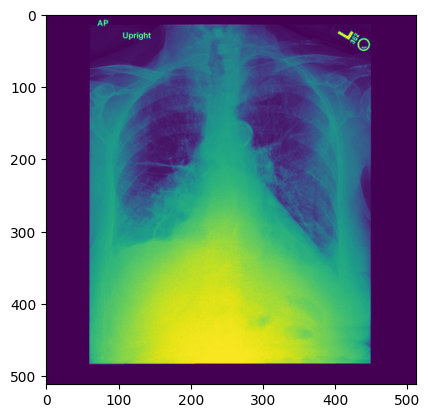

In [49]:
generated_reports_txt_path = "inference/generated_reports_run22.txt"
generated_reports = []
ref_reports = []
bert_score = evaluate.load("bertscore")
sentence_tokenizer = spacy.load("en_core_web_trf")
tokenizer = get_tokenizer()

# if you encounter a spacy-related error, try upgrading spacy to version 3.5.3 and spacy-transformers to version 1.2.5
# pip install -U spacy
# pip install -U spacy-transformers

for i, image_path in tqdm(enumerate(images_paths)):
    print(ids[i])
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    image_tensor = get_image_tensor(image_path)  # shape (1, 1, 512, 512)
    generated_report = get_report_for_image(model, image_tensor, tokenizer, bert_score, sentence_tokenizer)
    generated_reports.append(generated_report)
    with open(reports_paths[i]) as f:
        ref_reports.append(f.read())

#for i, image_path in tqdm(enumerate(images_paths)):
    #show
    if i ==1:
        plt.imshow(image_tensor.detach().cpu().numpy()[0][0])
        #plt.imshow(image, cmap='gray')
        print("generated reports: ", generated_reports[i])
        print("reference report: ", ref_reports[i])

write_generated_reports_to_txt(images_paths, ref_reports, generated_reports, generated_reports_txt_path)

(-0.5, 1735.5, 2021.5, -0.5)

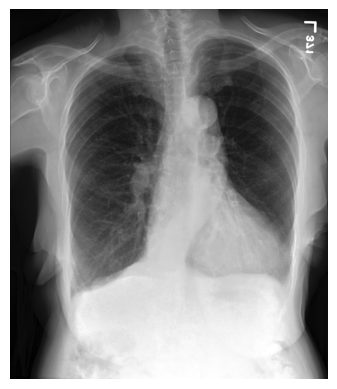

In [30]:
#load im

path = "/home/hermione/Documents/data/physionet.org/files/mimic-cxr-jpg/2.0.0/files/p10/p10032409/s55250890/35b006d3-53b9d561-d46bbbe3-69a82eaa-677f1241.jpg"

image = cv2.imread(path, cv2.IMREAD_UNCHANGED)
plt.imshow(image, cmap='gray')
plt.axis("off")